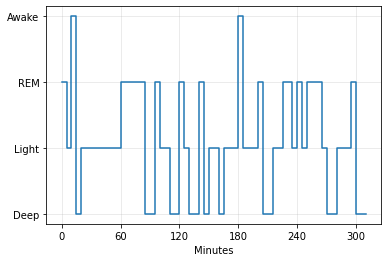

In [1]:
import os
import scipy.io as sio
import numpy as np
import rri
import joblib
import matplotlib.pyplot as plt

filepath = "./SWMInHouse_546C0ED02610_1621268901344_Vicent_sleep_0518.mat"

# Load .mat file
MAT = sio.loadmat(filepath)
ecgLen = MAT['len_ECG'][0][0]
Fs = MAT['Fs'][0][0]
R = MAT['R'].flatten()
Rm = MAT['Rm'].flatten()
Ridx = np.union1d(R, Rm)

# Calculate N-N intervals
window = 5*60*Fs # 5 minutes
segNum = ecgLen//window
Datas = []
for seg in range(segNum):
    segment = np.arange(seg*window,(seg+1)*window)
    covered_beat = np.intersect1d(Ridx,segment)
    NNIs = rri.filter(covered_beat, Fs)
    if len(NNIs)>0:
        Datas.append(NNIs)

# Extract Features
feature_list = {'time':True,'freq':True,'poincare':False}
Features = []
for data in Datas:
    feature_name, feature_value = rri.get_features(data,feature_list)
    Features.append(feature_value)

# Load model and predict
model = joblib.load("./clf_mixed.pkl")
pred = model.predict(Features)

# Plot figure
stage = []
for p in pred:
    if p == 0:
        stage.append(0)
    if p == 1:
        stage.append(-2)
    if p == 2:
        stage.append(-3)
    if p == 3:
        stage.append(-1)
tt = np.arange(0,5*len(stage),5)
fig, ax = plt.subplots()
ax.step(tt, stage, where='post')
ax.set_yticks(range(0,-4,-1))
ax.set_yticklabels(['Awake','REM','Light','Deep'])
ax.set_xticks(range(0,tt[-1],60))
ax.set_xlabel('Minutes')
ax.grid(alpha=0.3)
ax.set_facecolor('w')